In [3]:
import pandas as pd
import numpy as np
import seaborn as sns

data = pd.read_csv('../datasets/new_synthetical_dataset.csv')
data.head(5)

Index                                     Address  \
0      1  0x00009277775ac7d0d59eaad8fee3d10ac6c805e8   
1      2  0x0002b44ddb1476db43c868bd494422ee4c136fed   
2      3  0x0002bda54cb772d040f779e88eb453cac0daa244   
3      4  0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e   
4      5  0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89   

   Time Diff between first and last (Mins)  Face Attempts  \
0                                704785.63              1   
1                               1218216.73              2   
2                                516729.30              1   
3                                397555.90              1   
4                                382472.42              1   

   Detected As a Robot At Least Once  Face Match Percentage  \
0                                  0              89.325800   
1                                  0              89.223798   
2                                  0              90.412612   
3                                  0              98.420949   
4                                  0              93.742986   

   Liveness Score of The Face  FLAG  
0                       93.74     0  
1                       92.21     0  
2                       99.88     0  
3                       90.91     0  
4                       90.98     0

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9841 entries, 0 to 9840
Data columns (total 8 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   Index                                    9841 non-null   int64  
 1   Address                                  9841 non-null   object 
 2   Time Diff between first and last (Mins)  9841 non-null   float64
 3   Face Attempts                            9841 non-null   int64  
 4   Detected As a Robot At Least Once        9841 non-null   int64  
 5   Face Match Percentage                    9841 non-null   float64
 6   Liveness Score of The Face               9841 non-null   float64
 7   FLAG                                     9841 non-null   int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 615.2+ KB


In [5]:
train_data = data.copy()

In [6]:
from Crypto.Hash import keccak

def hash_address(address):
    keccak_hash = keccak.new(digest_bits=256)
    keccak_hash.update(address.encode())
    decimal_address = int(keccak_hash.hexdigest(), 16)
    return decimal_address

train_data['Address'] = train_data['Address'].apply(hash_address)
train_data['Address']

0       1029047895622181677082469178525025497239514033...
1       4815723412368990051845724797393104504732869074...
2       2267735954664873608345593168102949699911173861...
3       4816189373093903701735752654589308415626257088...
4       1075129388385622703205300713771774172281445551...
                              ...                        
9836    9796640894092615620455712647689124977578652145...
9837    1161781100425295333303255116631183873055342538...
9838    3258899527227816394779062129406231769231685409...
9839    6495764806995869469487631250138285433318644209...
9840    1808180123772589239611473807552879038033015564...
Name: Address, Length: 9841, dtype: object

In [7]:
min(train_data['Address']), max(train_data['Address'])

(6916888273301919839494136598466689873733750117887819555855366265435264500,
 115785804335479085432931386094244858531505116412641089759401603616989508692117)

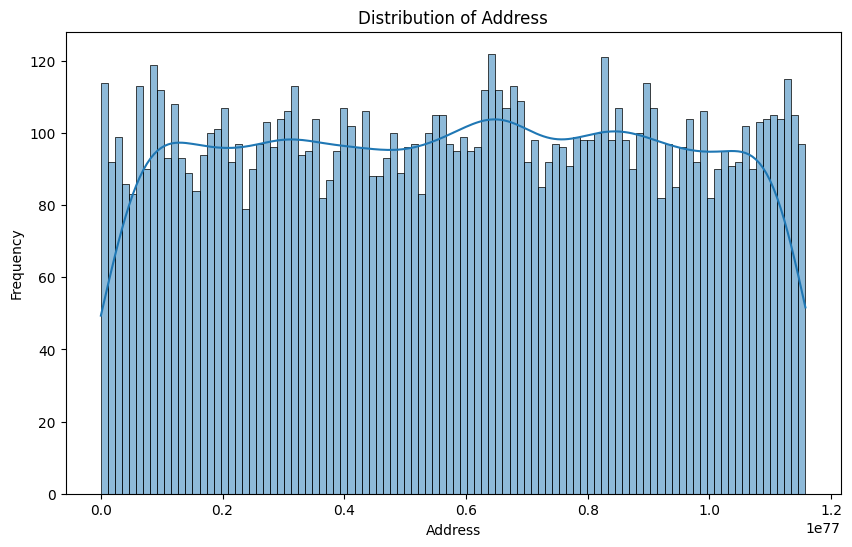

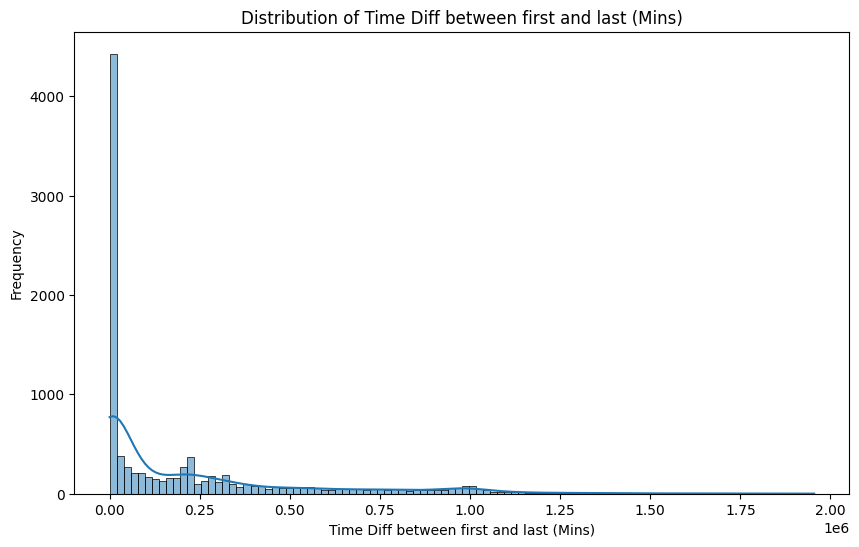

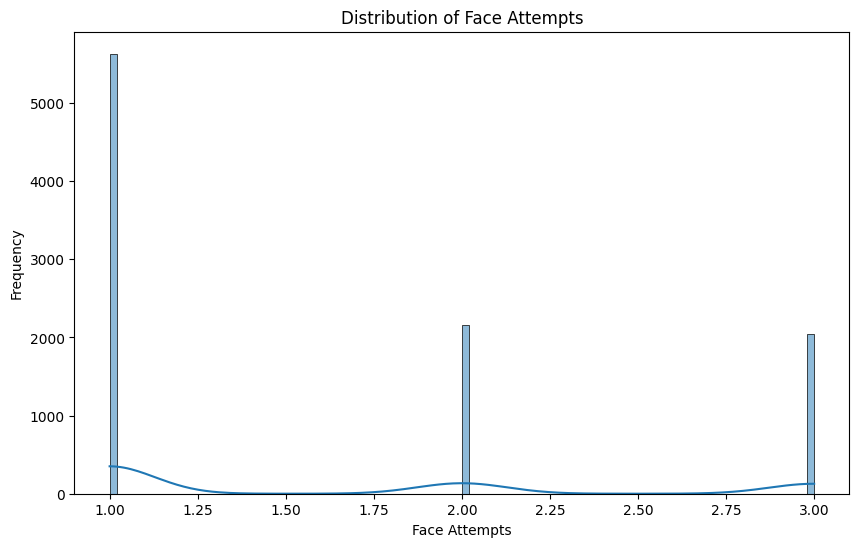

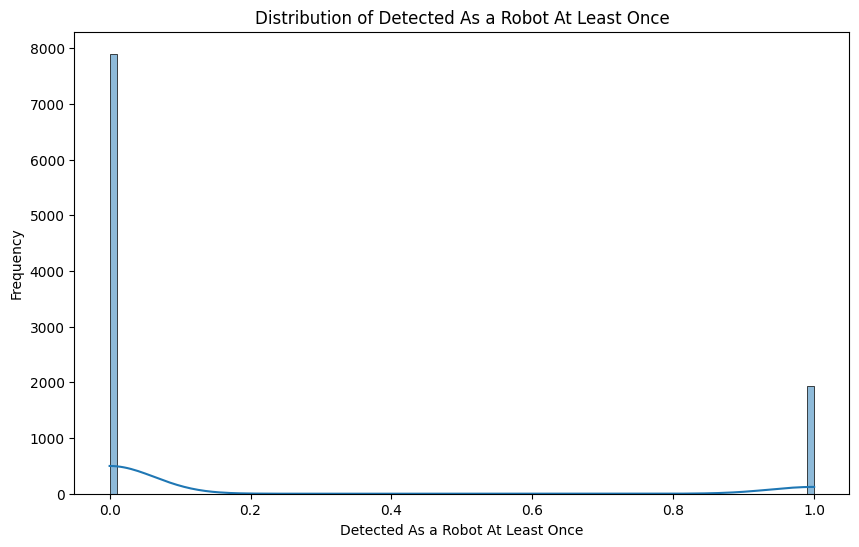

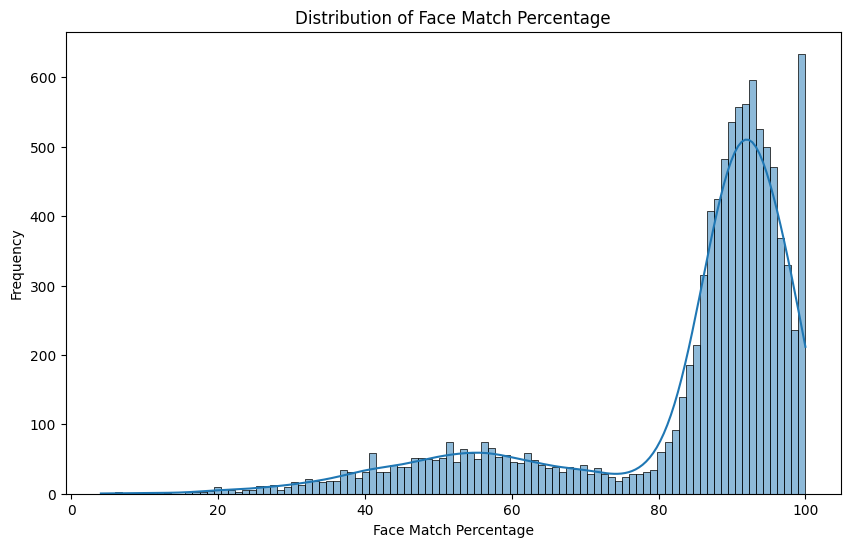

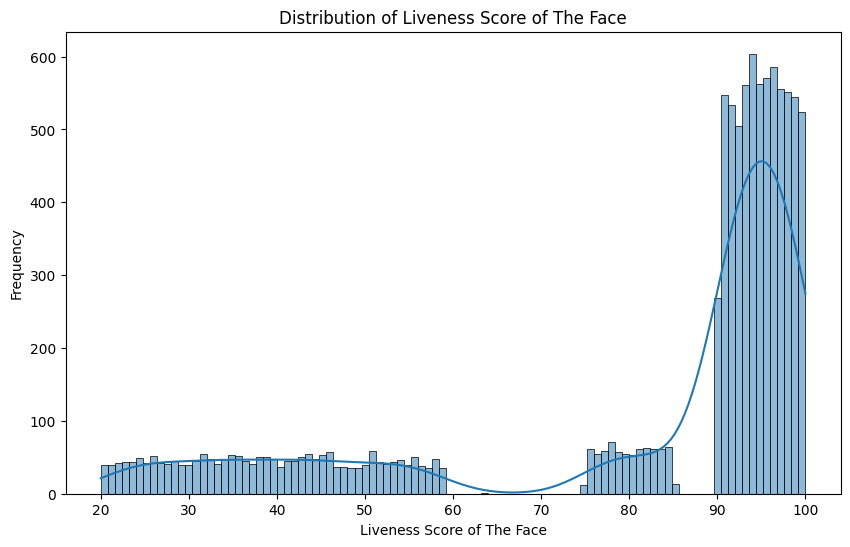

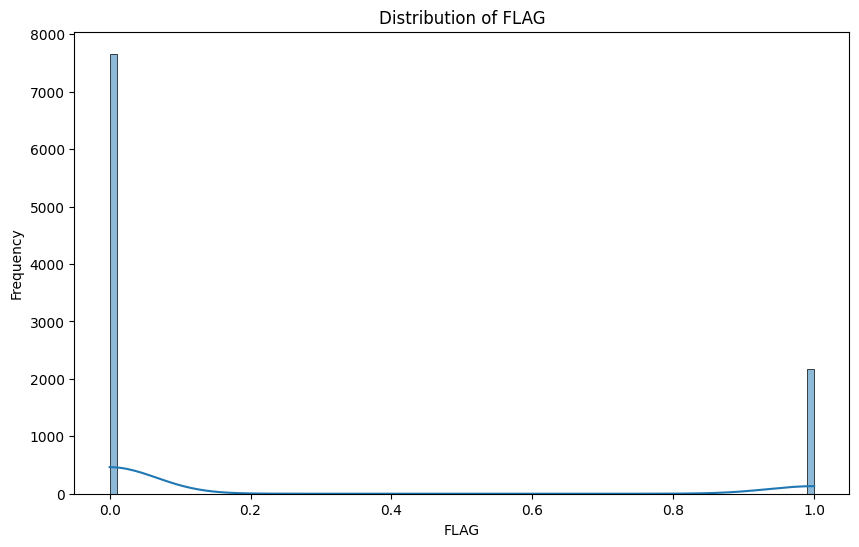

In [8]:
import matplotlib.pyplot as plt

cols = train_data.drop(columns=['Index']).columns
for col in cols:
    plt.figure(figsize=(10, 6))
    sns.histplot(train_data[col], bins=100, kde=True)
    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.show()

In [9]:
train_data.skew().sort_values(ascending=False)

Time Diff between first and last (Mins)    1.809977
Detected As a Robot At Least Once          1.523609
FLAG                                         1.3421
Face Attempts                               0.75159
Index                                       0.57297
Address                                    -0.00933
Liveness Score of The Face                -1.386505
Face Match Percentage                     -1.659468
dtype: object

In [10]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

for col in train_data.drop(columns=['Index', 'FLAG']):
    train_data[col] = scaler.fit_transform(train_data[col].values.reshape(-1, 1))

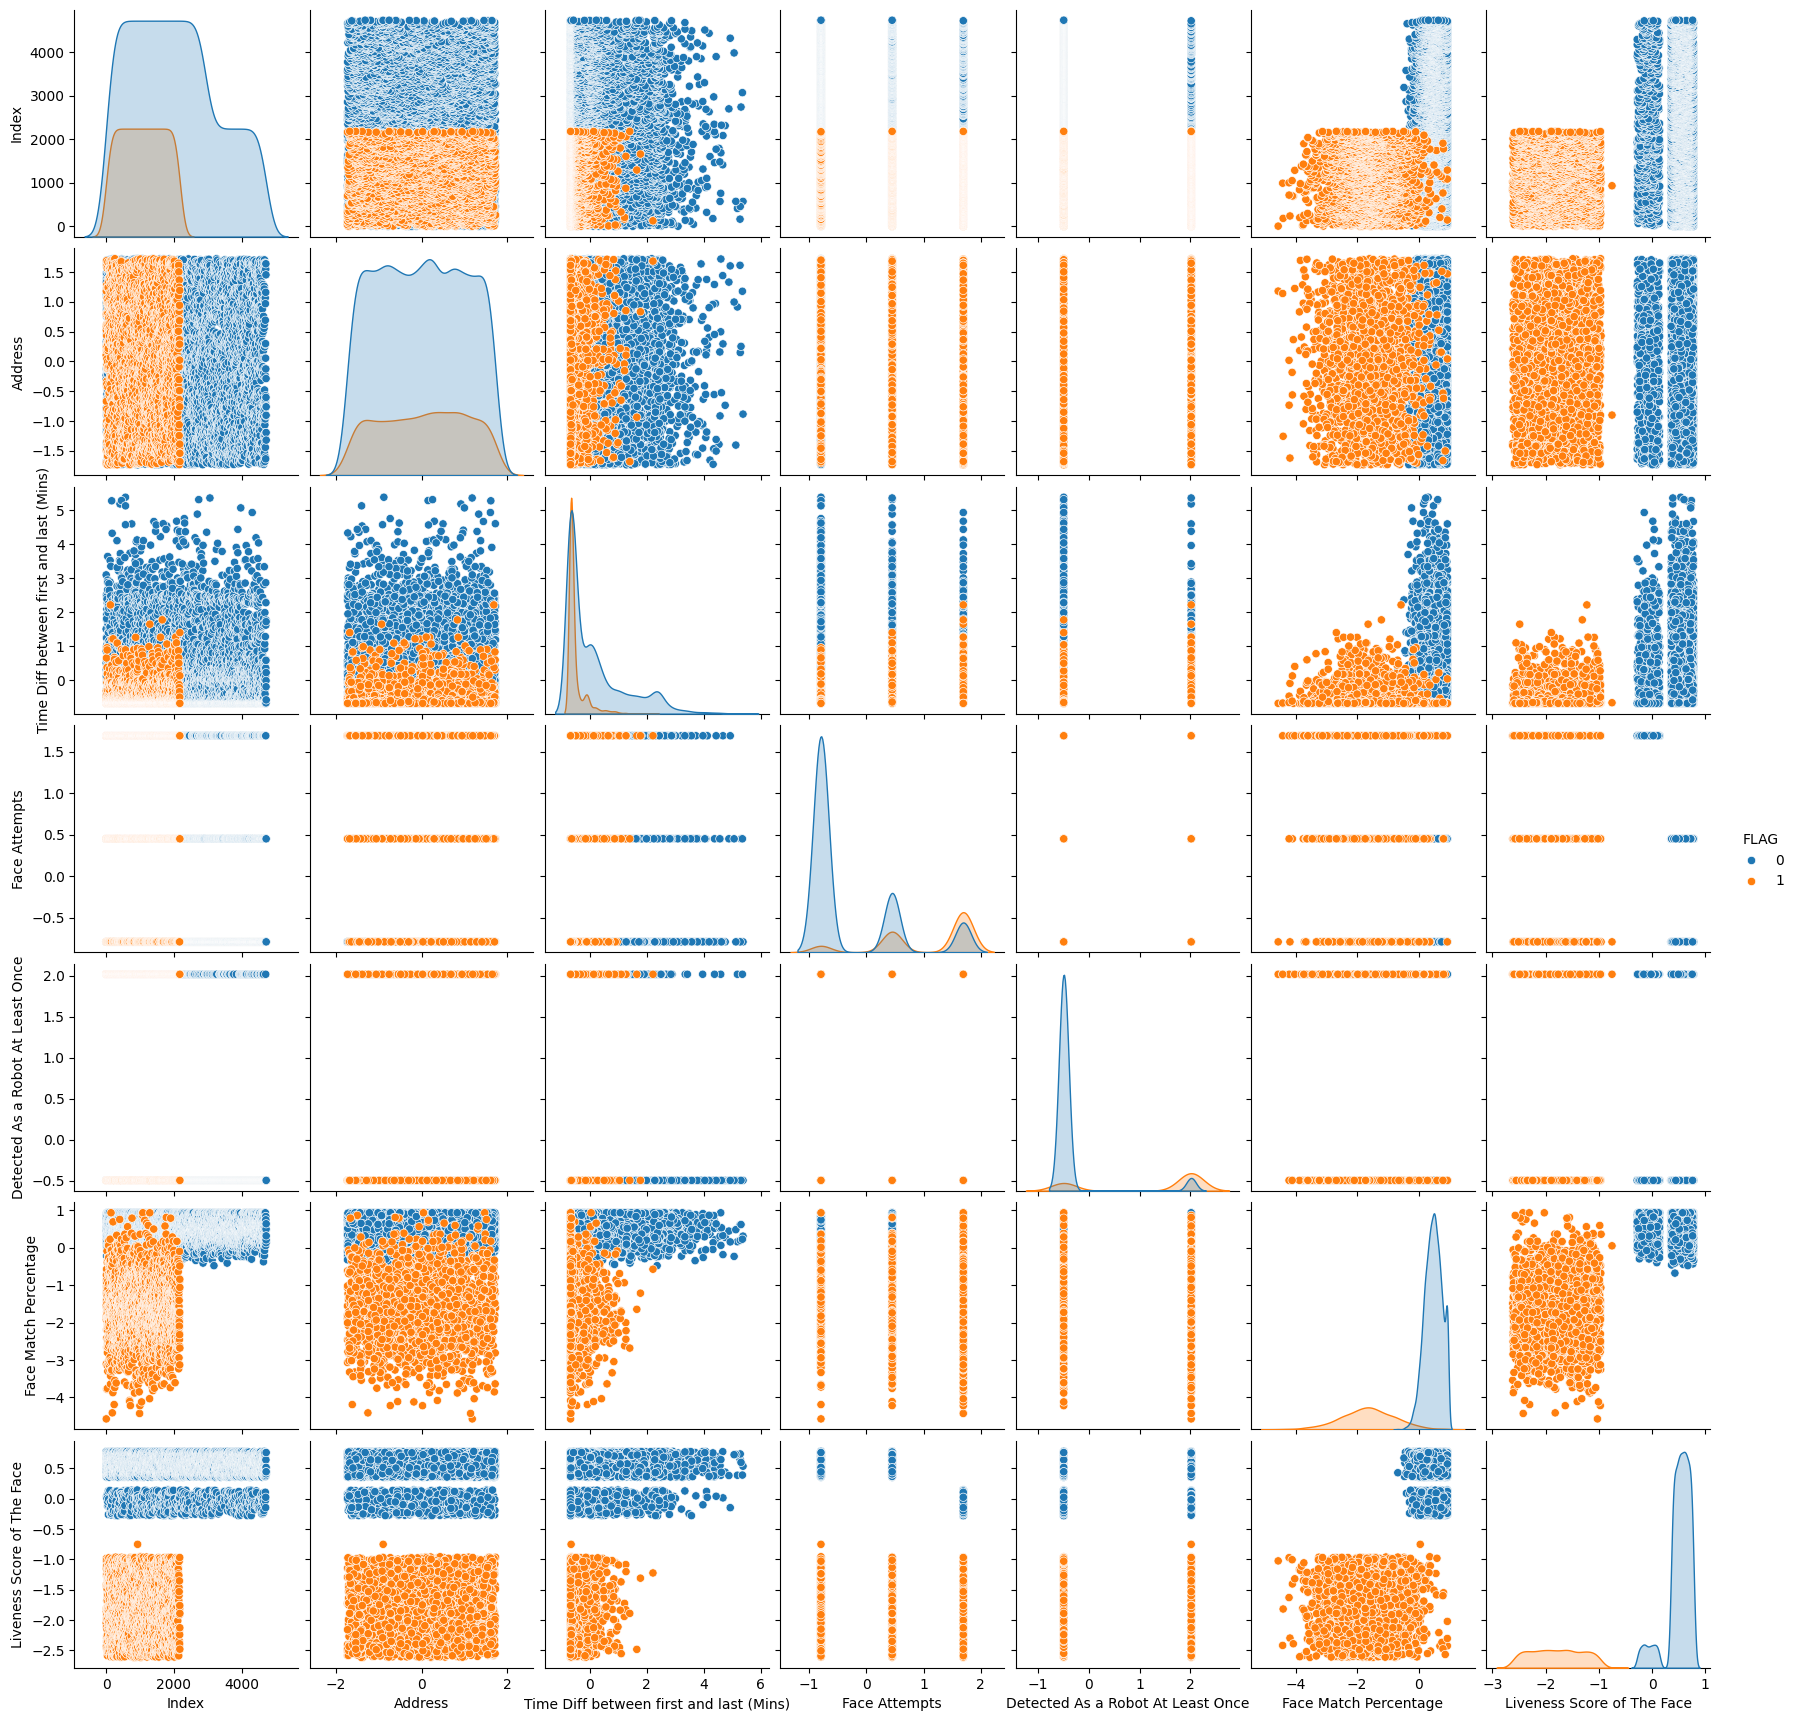

In [11]:
sns.pairplot(data=train_data, diag_kind='kde', hue='FLAG')
plt.show()

In [12]:
from sklearn.ensemble import IsolationForest

iso_forest_model = IsolationForest(contamination=0.1, random_state=42)
iso_forest_model.fit(train_data.drop(columns=['Index', 'FLAG']))

train_data['anomaly'] = iso_forest_model.predict(train_data.drop(columns=['Index', 'FLAG']))
train_data['anommaly'] = train_data['anomaly'].replace({1: 0, -1: 1}, inplace=True)

train_data['anomaly'].value_counts()

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_26436\940866785.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['anommaly'] = train_data['anomaly'].replace({1: 0, -1: 1}, inplace=True)


anomaly
0    8857
1     984
Name: count, dtype: int64

In [13]:
train_data[['anomaly', 'FLAG']].value_counts()

anomaly  FLAG
0        0       7373
         1       1484
1        1        695
         0        289
Name: count, dtype: int64

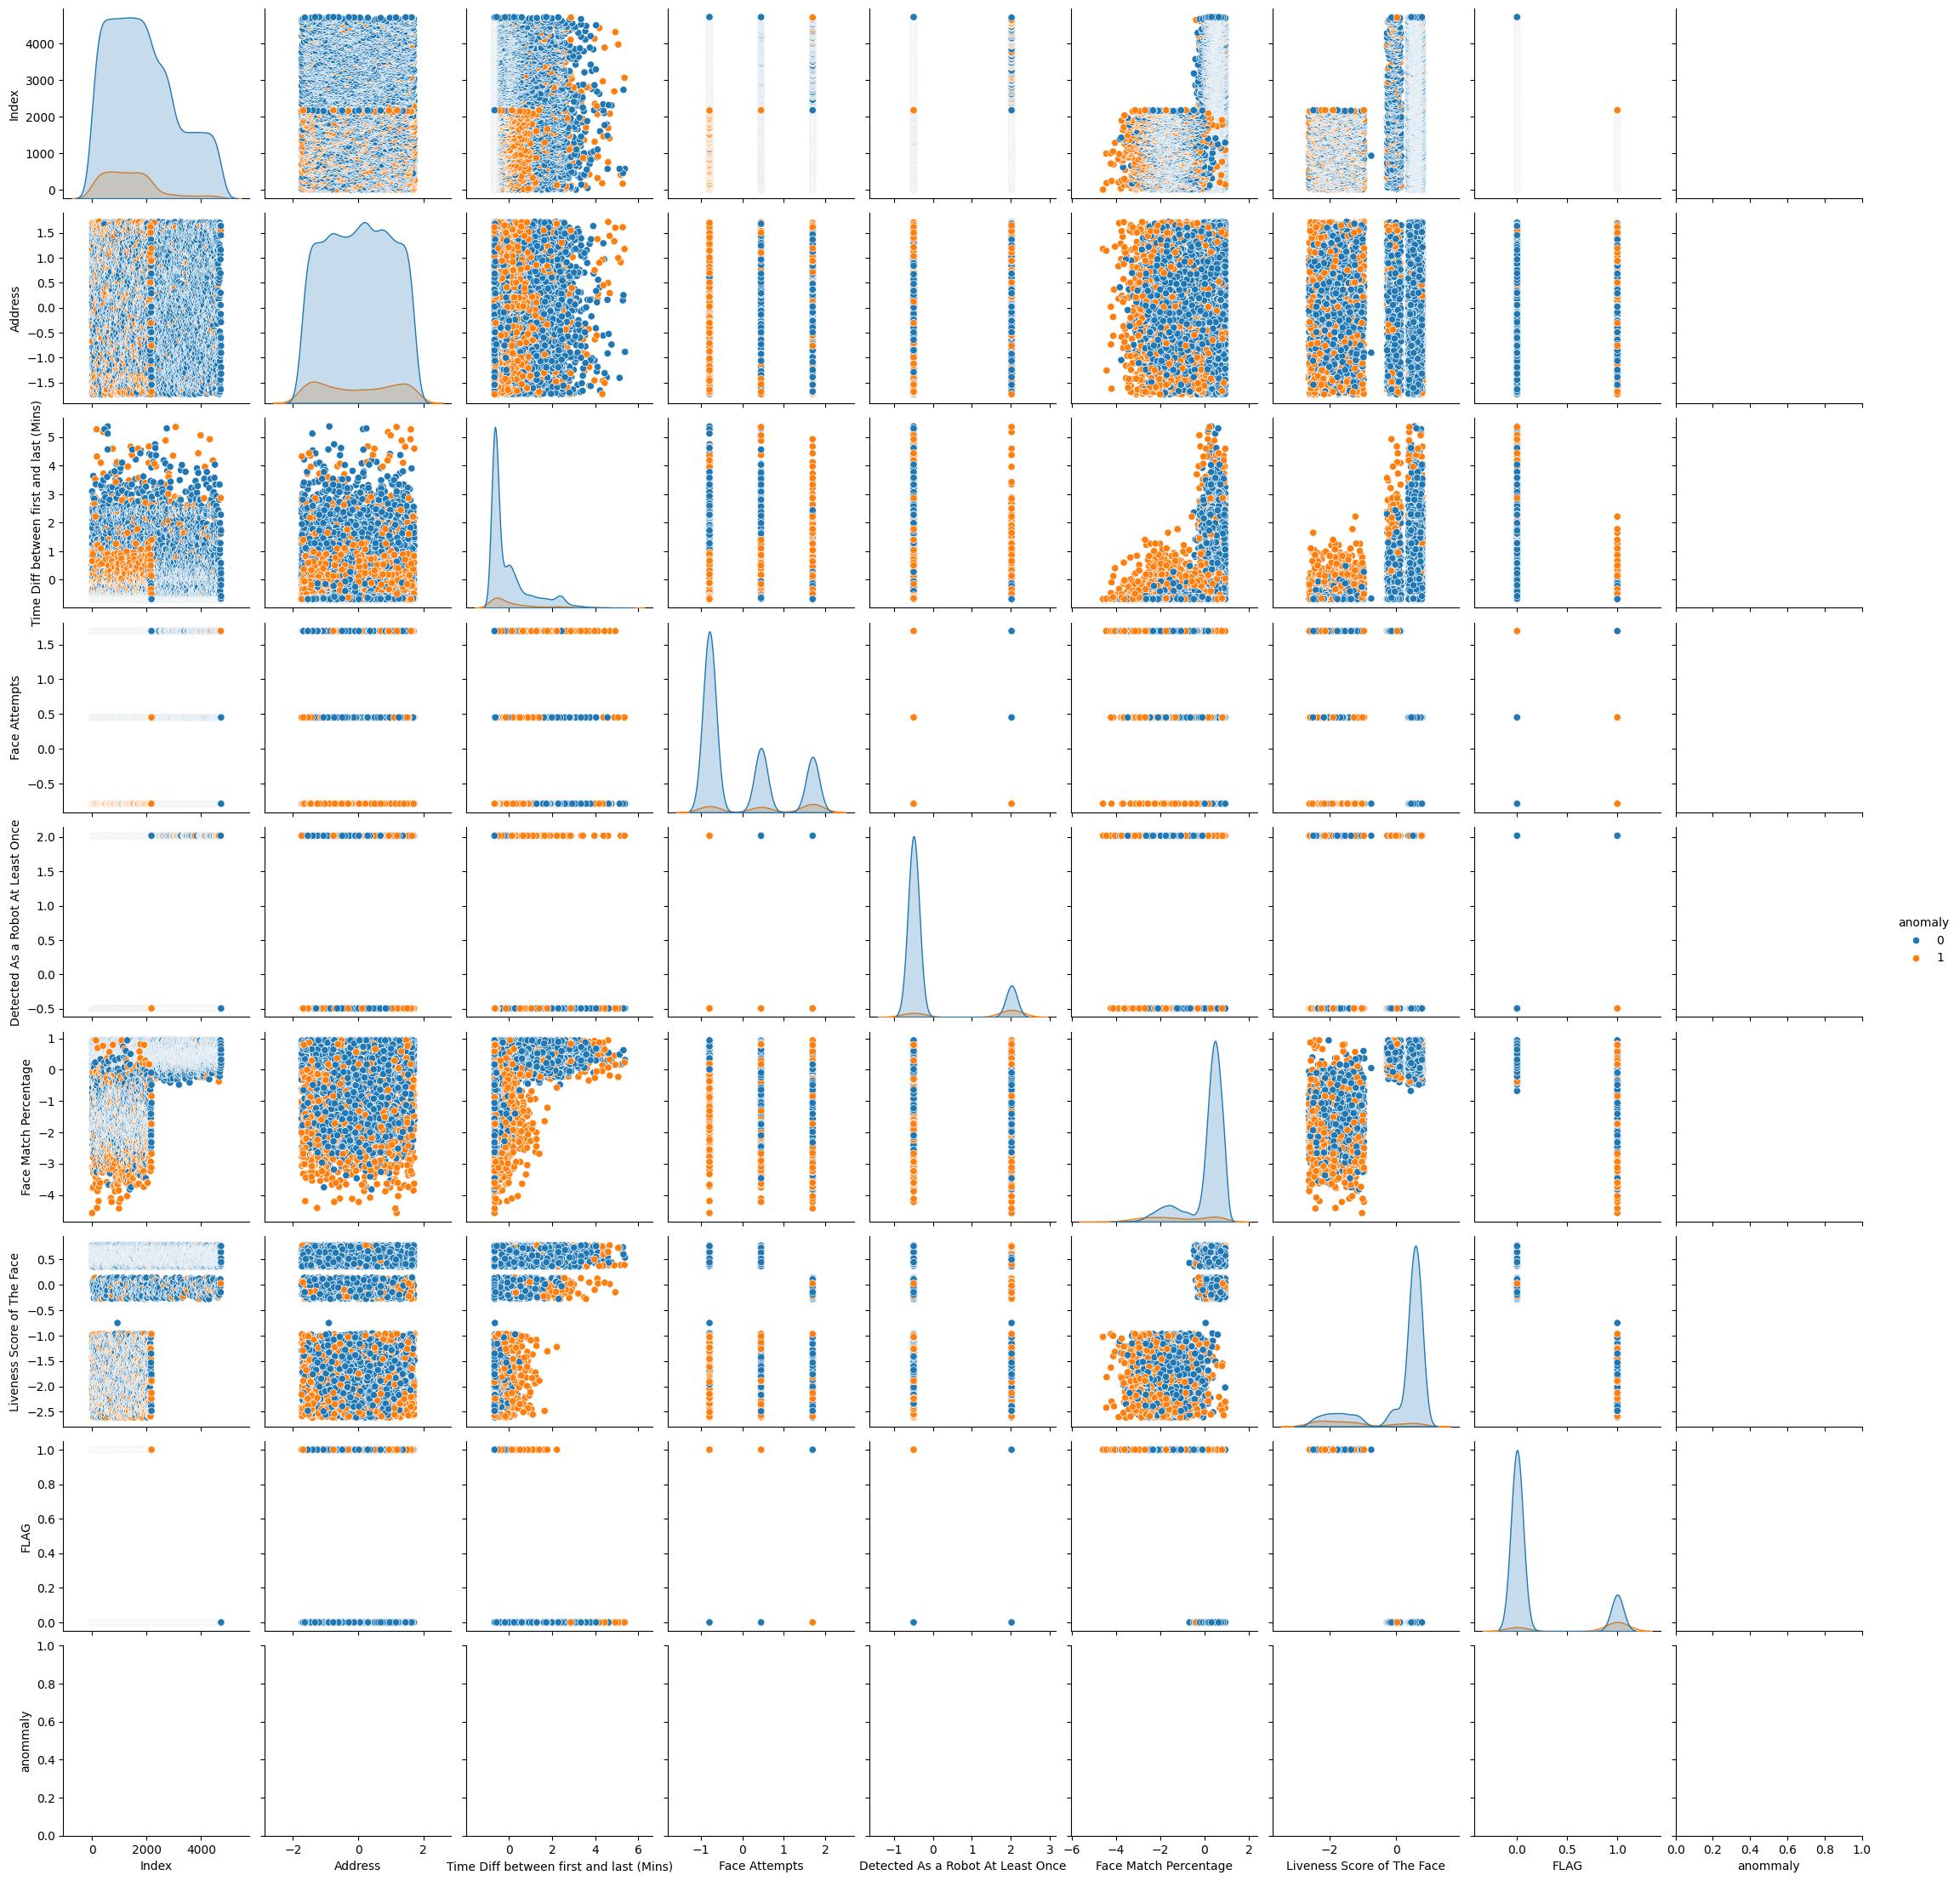

In [14]:
sns.pairplot(data=train_data, diag_kind='kde', hue='anomaly')
plt.show()

In [16]:
import joblib

joblib.dump(iso_forest_model, '../../model/isolation_forest_model.pkl')

['../../model/isolation_forest_model.pkl']

In [20]:
isolation_forest_preds = pd.DataFrame({
    'Address': data['Address'],
    'Anomaly': train_data['anomaly'],
    'FLAG': data['FLAG']
})
isolation_forest_preds.to_csv('../datasets/isolation_forest_preds.csv', index=False)

In [21]:
output = pd.read_csv('../datasets/isolation_forest_preds.csv')
output['FLAG'].value_counts()

FLAG
0    7662
1    2179
Name: count, dtype: int64

In [22]:
output[output['FLAG'] == 1].head(10)

Address  Anomaly  FLAG
7662  0x0020731604c882cf7bf8c444be97d17b19ea4316        0     1
7663  0x002bf459dc58584d58886169ea0e80f3ca95ffaf        0     1
7664  0x002f0c8119c16d310342d869ca8bf6ace34d9c39        0     1
7665  0x0059b14e35dab1b4eee1e2926c7a5660da66f747        0     1
7666  0x005b9f4516f8e640bbe48136901738b323c53b00        1     1
7667  0x00650a784ee109797ba8c05f3496bdbf2b2b7a1c        1     1
7668  0x0084515449b037205a33d6d3940a5684126aa4b5        0     1
7669  0x008f3db10374099a11ec263415cb88c952abeedc        1     1
7670  0x00c8bd3cd1e649a3fd2a89b3edc1c2ab631227a0        1     1
7671  0x00d07f8c2194f14c8d694680f2b8c0be66d4d5e9        1     1

In [23]:
data[data['Address']=='0x00c8bd3cd1e649a3fd2a89b3edc1c2ab631227a0']

Index                                     Address  \
7670      9  0x00c8bd3cd1e649a3fd2a89b3edc1c2ab631227a0   

      Time Diff between first and last (Mins)  Face Attempts  \
7670                                      0.0              1   

      Detected As a Robot At Least Once  Face Match Percentage  \
7670                                  1              51.824401   

      Liveness Score of The Face  FLAG  
7670                       58.39     1